# Training a classifier on the features extracted using Media Pipe's Face Mesh.

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
train_df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

Train shape: (26784, 24)
Val shape: (6599, 24)


In [4]:
# Features are all f0..fN columns, label column is the emotion name
X_train = train_df.drop(columns=["label"]).values
y_train_labels = train_df["label"].values

X_val = val_df.drop(columns=["label"]).values
y_val_labels = val_df["label"].values

# Encode string labels (angry, happy, etc) into integers 0..K-1
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_val = label_encoder.transform(y_val_labels)

print("Classes:", label_encoder.classes_)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


### Model Selection

In [5]:
from sklearn.model_selection import StratifiedKFold

# Common CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define candidate models inside pipelines
models = {
    "log_reg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "svc": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
    ]),
    "rf": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced_subsample"
    ),
    "gb": GradientBoostingClassifier(
        random_state=42
    ),
}

# Evaluate each model with cross validation on the training set
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    cv_results[name] = scores
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")


log_reg: mean=0.4500, std=0.0028
svc: mean=0.4919, std=0.0014
rf: mean=0.5541, std=0.0051
gb: mean=0.5122, std=0.0051


In [7]:
best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print("Best model from CV:", best_model_name)
model = models[best_model_name]


Best model from CV: rf


### Hyperparameter Tuning for Best Model

In [8]:
grid = GridSearchCV(
    estimator=model,
    param_grid={
        "n_estimators": [100, 200, 400],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
    },
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best CV accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

model = grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/envs/ecs179/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best CV accuracy: 0.5555927675123863
Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 400}


### Evaluation

In [10]:
y_val_pred = model.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Detailed metrics
print("\nClassification report (per class):")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=label_encoder.classes_
))

Validation accuracy: 0.5663

Classification report (per class):
              precision    recall  f1-score   support

       angry       0.51      0.41      0.45       864
     disgust       0.85      0.35      0.49        98
        fear       0.52      0.26      0.35       927
       happy       0.76      0.79      0.77      1763
     neutral       0.44      0.61      0.51      1175
         sad       0.41      0.45      0.43      1019
    surprise       0.67      0.72      0.69       753

    accuracy                           0.57      6599
   macro avg       0.59      0.51      0.53      6599
weighted avg       0.57      0.57      0.56      6599



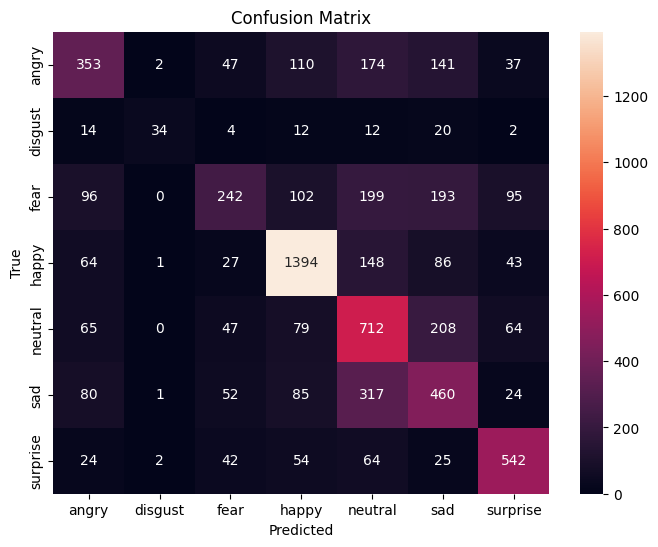

In [12]:
# confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_val, y_val_pred),
    annot=True,
    fmt="d",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Export

In [13]:
import joblib

# Save trained classifier
joblib.dump(model, "emotion_model.joblib")

# Save label encoder (to go back from integers to strings like "happy")
joblib.dump(label_encoder, "label_encoder.joblib")

print("Saved emotion_model.joblib and label_encoder.joblib")

Saved emotion_model.joblib and label_encoder.joblib


In [14]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

from sklearn.metrics import accuracy_score
print("Train acc:", accuracy_score(y_train, train_pred))
print("Val acc:", accuracy_score(y_val, val_pred))


Train acc: 0.9968637992831542
Val acc: 0.5662979239278678
